<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/Alexnet_20_Multiclass_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Faces: Using a CNN model to Classify Unseen Faces in the 'Labelled Faces in the Wild' Dataset

The 'Labelled Faces in the Wild' (LFW) data set is a collection of 13,233 images of celebrity faces collected from the web, with the individual in each image manually labelled. The dataset is designed for exploring, creating and testing image recognition algorithms.<br/>

In this notebook, we will be attempting to run an algorithm that can successfully identify faces in the dataset after having been trained on similar faces. We will also consider the limitations of this approach in terms of applying the algorithm to real-world data. <br/>

The notebook is structured as follows:

**1. Library Installation and Data Read-in** <br/>
Rudimentary data cleaning to ensure data is structured in intuitive data frames <br/>
**2. Exploratory Data Analysis (EDA)** <br/>
Data exploration, visualisations, and splitting the data into training/test/validation sets <br/>
**3. Evaluation Metric Decisions** <br/>
What is the most meaningful evaluation metric to use in this situation? <br/>
**4. Model Construction** <br/>
We discuss a number of candidate computer vision (CV) algorithms and assess the accuracy of CNN techniques on test data <br/>
**5. Results Analysis** <br/>
Discussion of results and their interpretations <br/>
**6. Conclusion and Next Steps** <br/>
A discussion of this approach, real-world applications, limitations, and possible future extensions

# 1. Library installation and data read-in

In [72]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lfw-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F26922%2F34595%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240326%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240326T212245Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D47188d89de02dbe96dc89ecd5ce5e106ddf6e6acfb7454f89936c492a01ed0f69356143c010f8976df34f7560270cd4c8f74b7f403a641e59211e7af91fea3c4532c7f36db0850b21286b3eaee3fd2c31d066582ea48b841c60cb36a71c8284276c776d8e709c7b66a6c1bdbdd615983115f17cb88a7a740450fb5394916fbca6ae942183990ed741556f64204257b2c8cdc55376fe9370f145cc326af39174d7bde2dd897404003691b872db22ecb097d35ad1fc725aa2ae5627975468ad33e8926bb9cdfbaa9368ba697b5bb6cc84752810bb7893a2e3143332f904770e79c59b812c1883d4134c4f9b924d62703c980914a0207610edccd82415474e1b13b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117895655 bytes downloaded
Downloaded and uncompressed: lfw-dataset
Data source import complete.


In [73]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

In [74]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("../input/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("../input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")
# tidy pairs data:
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("../input/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("../input/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("../input/lfw-dataset/peopleDevTrain.csv")

# 2. Exploratory Data Analysis (EDA)

In [75]:
print("Summary:")
print("There are " +
      str(lfw_allnames.shape[0]) +
      " unique celebrities in the entire dataset, of whom " +
      str(sum(lfw_allnames.images > 1)) +
      " are represented by multiple images. The entire number of images available is " +
      str(sum(lfw_allnames.images)) +
      ". The most represented celebrity is " +
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) +
      ", with " +
      str(max(lfw_allnames.images)) +
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


In [76]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

809
858


<ipython-input-76-071ffe1205ed>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  image_paths = image_paths.drop("images",1)
<ipython-input-76-071ffe1205ed>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_train = lfw_train.reset_index().drop("index",1)
<ipython-input-76-071ffe1205ed>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_test = lfw_test.reset_index().drop("index",1)


### Image format exploration

In [77]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


### Further data exploration

One of the drawbacks of the LFW dataset is that if has significant class imbalance. This can be dealt with using selective sampling, but it is useful to get an indication of the scale of the imbalance:

<Axes: >

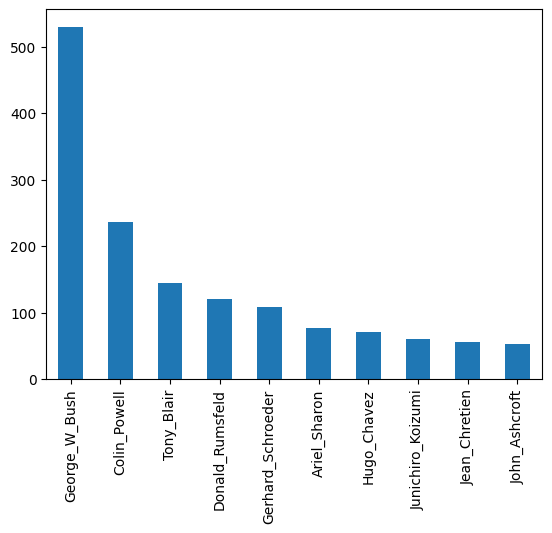

In [78]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

We can see that there are some very well-represented figures among the top 10: generally political and generally male. This has important implications for the usefulness of this dataset in generalizations, which we consider in the conclusion. To draw this further into distinction, how many individuals are represented by a single image, compared to George W Bush's 530?

In [79]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


As a sanity check, and to check the directories are all correctly connected, we visualize a sample image:

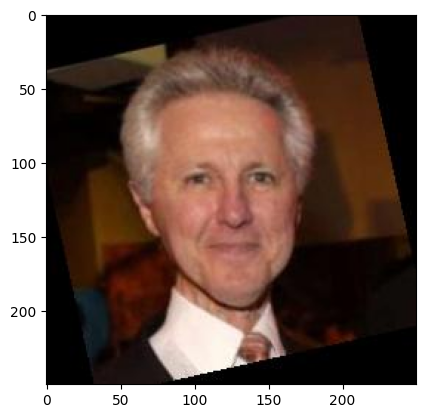

In [80]:
im = Image.open("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

1/1 [==============================] - 0s 297ms/step


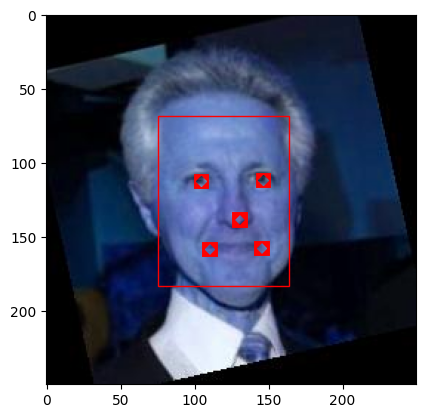

In [81]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

In [82]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [83]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [84]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [85]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


##Building a classifier Using the VGG in architecture

##Building a Classifier using the AlexNet Architecture

The model is now ready to run, but there is a final step required: the model will read training files from a dedicated training folder, so we need to make sure all the images are in folders with the correct labels.

In [86]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name))

        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name,data_type))
        path_from = os.path.join('../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('/kaggle/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1

    print('Moved {} images to {} folder.'.format(co,dir_name))

Now all the images are in the relevant training/test folders, we can run our CNN algorithm.

Now that the model is operational, we can look at the relationship between the training and validation loss to see if overfitting is likely to have taken place:

Given the relatively low number of epochs, the model still appears to be converging - the validation loss/accuracy is instable, which is also a function of the validation method (in future iterations, cross validation would be a preferable method). However, accuracy is generally high on both sets, indicating that the model is performing well. To confirm the model's performance, we look at the precision and recall on the (unseen) test set, comparing accuracy with the true labels:

In [87]:
# Alexnet_bush_history = alexnet.fit(Bush_training_set,
#                                              # set steps per epoch equal to the number of training images
#                                              steps_per_epoch = 20,
#                                              # there is a six hour runtime limit on Kaggle Kernels, restricting the maximum epoch number
#                                              epochs = 10,
#                                              validation_data = Bush_val_set,
#                                              validation_steps = 5)

In [88]:
# alexnet.save("Alexnet_bush_classifier_model.h5")
# from keras.models import load_model

# # Load the saved model
# loaded_model = load_model("Alexnet_bush_classifier_model.h5")

In [89]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else:
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)


In [90]:
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame['Predictions']))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]

        # Check if the denominator for precision is zero
        if (tp + fp) > 0:
            precision.append(tp / (tp + fp))
        else:
            precision.append(0)

        # Accuracy should not cause division by zero since total_preds should not be zero
        accuracy.append((tp + tn) / total_preds)

        # Check if the denominator for recall is zero
        if (tp + fn) > 0:
            recall.append(tp / (tp + fn))
        else:
            recall.append(0)

    return accuracy, precision, recall


The meaning of these results will be considered further in the conclusion. Before proceding, we clear the workspace to ensure the Kernel can successfully run in the Kaggle infrastructure:

## 4. c. Classifying Faces: Multiple Classes Using a Classic CNN
The immediate logical extension of this problem is to extend analysis to multiple classes. With enough time, we could exactly replicate this approach on the entire dataset, using every identity as a separate class. However, given time constraints, we can consider a brief extension to explore the strengths and limitations of a simple CNN model. Instead of taking Bush and non-Bush images, we will take an arbitrary cut-off of the 6 most frequently occurring celebrities and attempt to classify the images.

In [91]:
# obtain 6 most common celebrities

image_paths['name'].value_counts()[:10]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: name, dtype: int64

There is a clear issue with class imbalance here: to ensure more balanced classes, we could up-sample some of the low-representation individuals, but in the interests of algorithmic speed we will instead down-sample the high-representation individuals:

In [92]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

We then run the model as before, adjusting for multiple classes:

In [93]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, Activation

# withhold final test data
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split into validation data
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# Same model setup as before
multi_classifier = Sequential()

# Block 1
multi_classifier.add(ZeroPadding2D((1,1), input_shape=(250, 250, 3)))
multi_classifier.add(Conv2D(64, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(64, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block2
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(128, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(128, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block3
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(256, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(256, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(256, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block 4
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

# Block 5
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

# Custom Classifier Layers
multi_classifier.add(Flatten())
multi_classifier.add(Dense(1024, activation='relu'))
multi_classifier.add(Dropout(0.5))
multi_classifier.add(Dense(1024, activation='relu'))
multi_classifier.add(Dropout(0.5))
# Output layer for categorical  classification
multi_classifier.add(Dense(6, activation='softmax'))

# Compile model
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [94]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

alexnet = Sequential()

# Layer 1
alexnet.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
alexnet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())

# Layer 4
alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())

# Layer 5
alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 6
alexnet.add(Flatten())
alexnet.add(Dense(4096, activation='relu'))
alexnet.add(Dropout(0.5))

# Layer 7
alexnet.add(Dense(4096, activation='relu'))
alexnet.add(Dropout(0.5))

# Layer 8 - Output layer for binary classification
alexnet.add(Dense(6, activation='softmax'))

# Compile the model
alexnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [95]:
# move images to separate directories
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('/kaggle/working/train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 8,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('/kaggle/working/val_multi/',
                                            target_size = (250, 250),
                                            batch_size = 8,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('/kaggle/working/test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 8,
                                            class_mode = 'categorical')

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 608 images belonging to 6 classes.
Found 199 images belonging to 6 classes.
Found 239 images belonging to 6 classes.


In [96]:
multi_history = alexnet.fit(multi_training_set,
                                               # set steps per epoch equal to the number of training images
                                               steps_per_epoch = 36,
                                               # as the data is smaller, we can run for more epochs
                                               epochs = 20,
                                               validation_data = multi_val_set,
                                               validation_steps = 9)

Epoch 1/20
36/36 [==============================] - 9s 129ms/step - loss: 38.8750 - accuracy: 0.2292 - val_loss: 946.4169 - val_accuracy: 0.2083
Epoch 2/20
36/36 [==============================] - 10s 291ms/step - loss: 15.1789 - accuracy: 0.1979 - val_loss: 39.1515 - val_accuracy: 0.1111
Epoch 3/20
36/36 [==============================] - 11s 303ms/step - loss: 7.8600 - accuracy: 0.1910 - val_loss: 7.8088 - val_accuracy: 0.2500
Epoch 4/20
36/36 [==============================] - 5s 126ms/step - loss: 4.0038 - accuracy: 0.2292 - val_loss: 2.7982 - val_accuracy: 0.2083
Epoch 5/20
36/36 [==============================] - 5s 148ms/step - loss: 2.5588 - accuracy: 0.2465 - val_loss: 2.4260 - val_accuracy: 0.1667
Epoch 6/20
36/36 [==============================] - 5s 127ms/step - loss: 2.3663 - accuracy: 0.2639 - val_loss: 1.6954 - val_accuracy: 0.3194
Epoch 7/20
36/36 [==============================] - 5s 135ms/step - loss: 2.3537 - accuracy: 0.2361 - val_loss: 2.1683 - val_accuracy: 0.1389

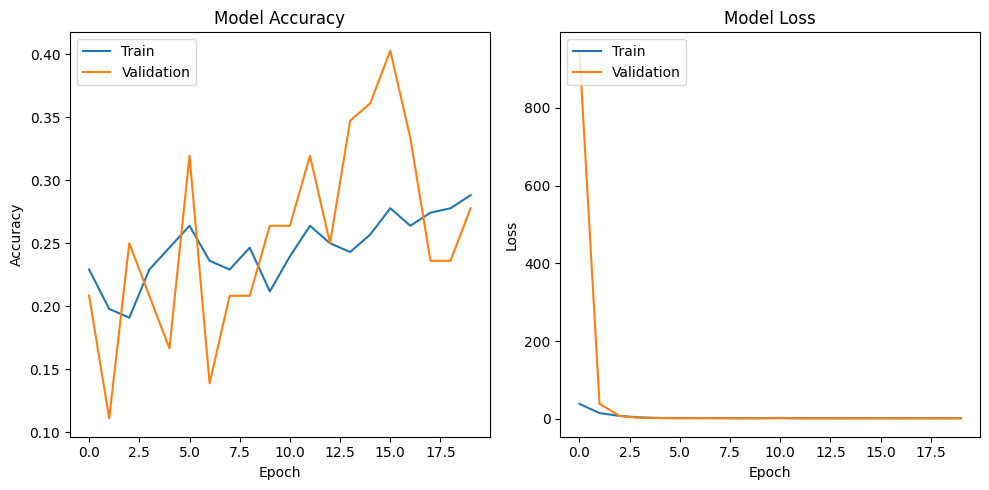

In [97]:
# Create a figure and a set of subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the accuracy on the first subplot
ax1.plot(multi_history.history['accuracy'])
ax1.plot(multi_history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the loss on the second subplot
ax2.plot(multi_history.history['loss'])
ax2.plot(multi_history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Adjust the layout so that the subplots fit into the figure area.
plt.tight_layout()

# Display the plots
plt.show()

Model loss appears broadly stable over 14 epochs; we do not seem to have reached the point of overfitting yet.

In [98]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
multi_test_names = []
# collect all file names
for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])
# extract unique names, in order
for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

In [99]:

multi_predictions_0 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[0] + "/",multi_classifier,binary=False)
multi_predictions_1 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[1] + "/",multi_classifier,binary=False)
multi_predictions_2 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[2] + "/",multi_classifier,binary=False)
multi_predictions_3 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[3] + "/",multi_classifier,binary=False)
multi_predictions_4 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[4] + "/",multi_classifier,binary=False)
multi_predictions_5 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[5] + "/",multi_classifier,binary=False)


1/1 [==============================] - 0s 20ms/step


In [100]:
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5))),
                                       columns = ['Predictions','Actual'])

In [101]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

Precision:[0, 1.0, 0]
Recall:[0.0, 0.027777777777777776, 0.0]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


These results will be considered in Section 5. Again, we want to drop the used image directories to allow the Kernel to run:

In [102]:
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")
if "val_multi" in os.listdir("./"):
    shutil.rmtree("./val_multi")
if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")


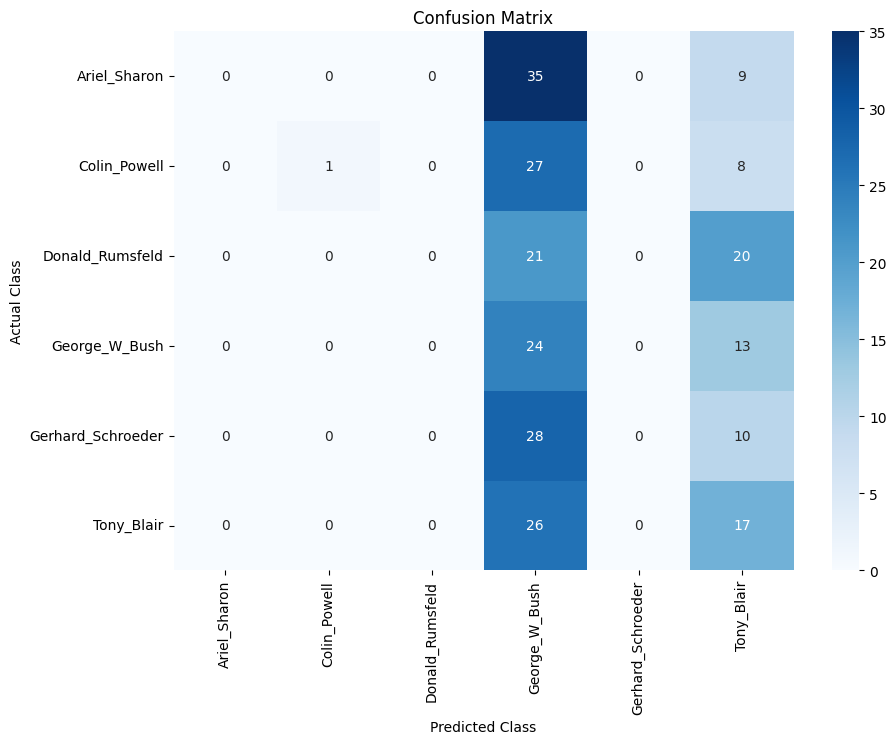

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming multi_predictions_frame already contains your model's predictions and the actual labels
# Convert predictions and actual values to numpy arrays if they aren't already
predictions = np.array(multi_predictions_frame['Predictions'])
actual = np.array(multi_predictions_frame['Actual'])

# Generate the confusion matrix
cm = confusion_matrix(actual, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=multi_test_name_order, yticklabels=multi_test_name_order)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()
